In [ ]:
!rm -rf "dataset"

In [ ]:
# !sudo apt update && sudo apt -y install git
# !git clone https://github.com/fastai/fastsetup.git
# !cd fastsetup
# !sudo ./ubuntu-wsl.sh

!pip install -U albumentations
!pip install shap
# !pip install --upgrade pillow==7.0.0 
!pip install fastai2_extensions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 KB 3.6 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.vision.widgets import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastcore.script import *
from fastai.vision.all import *
from fastai2_extensions.interpret.all import *
fastprogress.MAX_COLS = 80

import albumentations as A
import numpy as np
import shap
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import colorsys
from PIL import Image
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [ ]:
# Check GPU on Colabs
# NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2
! nvidia-smi 

Mon Apr 10 08:07:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# !cp '/home/bhavya/Monkeypox/Dataset_reduced.zip' 'dataset.zip'

folder = "dataset"

!cp '/content/drive/MyDrive/dataset2.zip' 'dataset.zip'
# This code snippet unzips a zip file to a specified destination
!unzip "dataset.zip" -d "/content";
classes = next(os.walk('/content/'+folder+'/'))[1]

Archive:  dataset.zip
   creating: /content/dataset/Training/
   creating: /content/dataset/Training/Chickenpox/
  inflating: /content/dataset/Training/Chickenpox/0.png  
  inflating: /content/dataset/Training/Chickenpox/0_aug0.png  
 extracting: /content/dataset/Training/Chickenpox/0_aug1.png  
  inflating: /content/dataset/Training/Chickenpox/0_aug2.png  
  inflating: /content/dataset/Training/Chickenpox/1.png  
  inflating: /content/dataset/Training/Chickenpox/1_aug0.png  
  inflating: /content/dataset/Training/Chickenpox/1_aug1.png  
  inflating: /content/dataset/Training/Chickenpox/1_aug2.png  
  inflating: /content/dataset/Training/Chickenpox/100.png  
  inflating: /content/dataset/Training/Chickenpox/100_aug0.png  
  inflating: /content/dataset/Training/Chickenpox/100_aug1.png  
  inflating: /content/dataset/Training/Chickenpox/100_aug2.png  
  inflating: /content/dataset/Training/Chickenpox/101.png  
  inflating: /content/dataset/Training/Chickenpox/101_aug0.png  
  inflating: 

In [ ]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path+"/Training")):
      num_files = len(sorted(os.listdir(path+"/Training"+'/'+folder)))
      cut_point = int(num_files*pct_images)

      for file in sorted(os.listdir(path+"/Training"+'/'+folder))[:cut_point]:
        data.append((folder, path+"/Training/"+folder+'/'+file, False))
  df = pd.DataFrame(data, columns=['Class', 'Path', 'is_valid'])

  data = []
  for folder in sorted(os.listdir(path+"/Validation")):
      num_files = len(sorted(os.listdir(path+"/Validation"+'/'+folder)))
      cut_point = int(num_files*pct_images)

      for file in sorted(os.listdir(path+"/Validation"+'/'+folder))[:cut_point]:
        data.append((folder, path+"/Validation/"+folder+'/'+file, True))
  df1 = pd.DataFrame(data, columns=['Class', 'Path', 'is_valid'])
  
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)+len(df1)} images.) Shuffle = {shuffle}.')
  return [df, df1]

In [ ]:
from tabulate import tabulate

@call_parse
def get_dataloader(
    img_path: Param("Path of dataset to use", str),
    split_path: Param("Path of dataset to use to pre-defiine split", str)=None,
    img_size: Param("Size in pixels", int)=224,
    pct_images: Param("Fraction of images to use", float)=1,
    bs: Param("Batch size", int)=64,
    deterministic: Param("Deterministic learner", bool)=True,
    randomerasing: Param("Random Erasing", str)=None,
    n_splits: Param("Number of folds in split", int)=5,
    shuffle: Param("Shuffle prior to splitting", bool)=True,
    fold: Param("Which fold to use", int)=0,
):
  #Get file path and labels from the dataframe we set up
  get_x = lambda x: x["Path"]
  get_y = lambda y: y["Class"]

  #Define splitting function that reads from a dataframe column
  def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()

    return train,valid

  #Prepare transforms
  #Image is generally larger initially 512px for later augmentations
  item_tfms = [RandomResizedCrop(512, min_scale=0.7)]
  #Batch transforms include a random resized crop to img_size px
  batch_tfms = [*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  #Add in randomerasing if necessary
  if randomerasing != None:
    batch_tfms = [*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  #Prepare Datablock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms)
  
  if split_path != None:
    print("Split Path defined, preparing pseudo stratified split.")
  #Create a dtaframe that defines a master split, based on split_path
  dfT, dfV = create_path_df(split_path, pct_images = 1)

  df = pd.concat([dfT, dfV], ignore_index=True)
  
  df['Path'] = df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-3:]))

  #Print info
  dls = data.dataloaders(df, bs=bs)
  
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {df['is_valid'].describe()['freq']/len(df['is_valid'])*100:.2f}% training data")
  return dls

In [ ]:
from fastai.vision.all import *

@call_parse
def create_simple_cnn_learner(
    size: Param("size", int)=224,
    bs: Param("Batch size", int)=64,
    arch: Param("Architecture", str)='resnet34',
    fp16: Param("Use mixed precision training", int)=0,
    deterministic: Param("Deterministic learner", bool)=True,
    pretrained: Param("Pretrained architecture", bool)=True,
    pct_images: Param("Fraction of images to use", float)=1,
    img_path: Param("Path of dataset to use", str)="/content/data",
    split_path: Param("Path of dataset to use to pre-defiine split", str)=None,
    model_dir: Param("Path to save model", str)="/content/drive/MyDrive/new/Model",
    log_name: Param("Name of csv training log", str)="history.csv",
    splitter: Param("Custom spllitter", str)=None,
):
  #Select optimization function
  opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, decouple_wd=True)
  #Set random seed
  if deterministic == True:
    random_seed(101,True)
  #Get Dataloader
  dls = get_dataloader(img_size=size, bs=bs, img_path=img_path, pct_images=pct_images, split_path=split_path)
  #Setup activation function and pooling
  model = globals()[arch]
  #Setup callbacks
  callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
  #Setup learner
  learn = vision_learner(dls,
                      model,
                      splitter=splitter,
                      pretrained=pretrained,
                      opt_func=opt_func,
                      metrics=[accuracy],
                      model_dir=model_dir,
                      cbs=callbacks)
  if fp16: learn = learn.to_fp16()
  return learn

In [ ]:
learn100 = create_simple_cnn_learner(pct_images=1, 
                           deterministic=True, 
                           size=448, 
                           img_path ='/content/'+folder+'/',
                           split_path = '/content/'+folder+'/',
                           log_name = '100baseline.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/dataset/, using 100.00% of the images (3417 images.) Shuffle = False.
We have 4 classes, with a training set of size 3200, and a validation set of size 217
The main split has 93.65% training data


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 89.1MB/s]


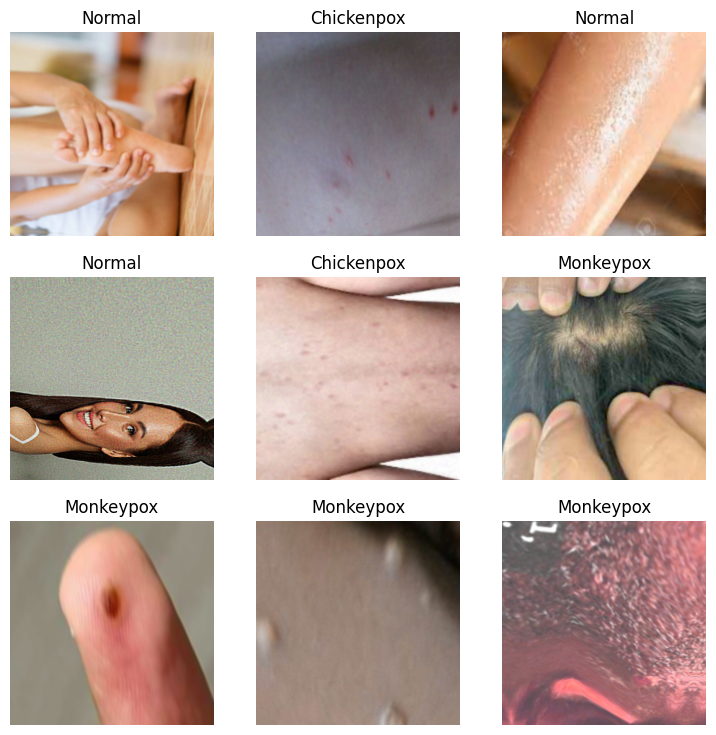

In [ ]:
learn100.dls.show_batch(max_n=9)

In [ ]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

In [ ]:
def baseline_fit(learn, name):
  print(f'Freezing model body')
  learn.freeze()
  enumerate_params(learn)
  s1 = learn.lr_find()
  print(s1)
  learn.fit_one_cycle(10, s1.valley)
  learn.save('stage-1-'+name)

  print(f'Unfreezing model body')
  learn.unfreeze()
  s2 = learn.lr_find()
  print(s2)
  enumerate_params(learn)
  learn.fit_one_cycle(30, s2.valley)
  learn.save('stage-2-'+name)

In [ ]:
baseline_fit(learn100, "100pct")

Freezing model body
21,814,080 total parameters.
546,432 training parameters.


In [ ]:
learn100.show_results()

In [ ]:
# Create learner from entire dataset
learn = create_simple_cnn_learner(pct_images=1, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/'+folder+'/',
                           split_path = '/content/'+folder+'/',
                           log_name = 'Lossbaseline.csv')

In [ ]:
# Load in a saved state
learn.load('/content/drive/MyDrive/new/Model/stage-2-100pct');

# Prepare interpretation class
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(6, figsize=(12,5))

In [ ]:
interp.plot_confusion_matrix(figsize=(12,5), dpi = 100)

In [ ]:
fname = "/content/"+folder+"/Validation/Monkeypox/103.png"
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

fname = "/content/"+folder+"/Validation/Normal/100.png"
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

fname = "/content/"+folder+"/Validation/Measles/10.png"
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

fname = "/content/"+folder+"/Validation/Chickenpox/10.png"
gcam = GradCam(learn, fname, None)
gcam.plot(full_size=True, plot_original=True, figsize=(12,6))

In [ ]:
# Use a jupyter magic command to capture the print output from the classification report
%%capture cap_out --no-stderr
interp.print_classification_report()

In [ ]:
classification_report = cap_out.stdout

from itertools import groupby
class_report = pd.DataFrame([])
def split_text(s):
    for k, g in groupby(s, str.isnumeric):
        yield ''.join(g)

report = []
for item in classification_report.split('\n'):
  report.append(split_text(item))

report = pd.DataFrame(report).copy()
class_report = pd.DataFrame([])
class_report['Class'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,0]
class_report['Precision'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,3].apply(lambda x:int(x)/100)
class_report['Recall'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,7].apply(lambda x:int(x)/100)
class_report['F1 Score'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,11].apply(lambda x:int(x)/100)
class_report['Support'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,13]

In [ ]:
class_report.sort_values("F1 Score")

In [ ]:
class_report.plot()

In [ ]:
dls = get_dataloader(img_size=224, bs=128, img_path='/content/'+folder+'/', pct_images=1, split_path='/content/'+folder+'/')
# pull a sample of our data (128 images)
batch = dls.one_batch()

# specify how many images to use when creating the background distribution
num_samples = 100
explainer = shap.GradientExplainer(
    learn100.model, batch[0][:num_samples]
)

# calculate shapely values
shap_values = explainer.shap_values(
    batch[0][num_samples:]
)

# import matplotlib.pyplot as pl
from shap.plots import colors

for idx, x in enumerate(batch[0][num_samples:]):
    x = x.cpu() # move image to CPU
    label = dls.train.vocab[batch[1][num_samples:]][idx]
    sv_idx = list(dls.train.vocab).index(label)

    # plot our explanations
    fig, axes = pl.subplots(figsize=(7, 7))

    # make sure we have a 2D array for grayscale
    if len(x.shape) == 3 and x.shape[2] == 1:
        x = x.reshape(x.shape[:2])
    if x.max() > 1:
        x /= 255.

    # get a grayscale version of the image
    x_curr_gray = (
        0.2989 * x[0,:,:] +
        0.5870 * x[1,:,:] +
        0.1140 * x[2,:,:]
    )
    x_curr_disp = x

    abs_vals = np.stack(
        [np.abs(shap_values[sv_idx][idx].sum(0))], 0
    ).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)

    label_kwargs = {'fontsize': 12}
    axes.set_title(label, **label_kwargs)

    sv = shap_values[sv_idx][idx].sum(0)
    axes.imshow(
        x_curr_gray,
        cmap=pl.get_cmap('gray'),
        alpha=0.3,
        extent=(-1, sv.shape[1], sv.shape[0], -1)
    )
    im = axes.imshow(
        sv,
        cmap=colors.red_transparent_blue, 
        vmin=-max_val, 
        vmax=max_val
    )
    axes.axis('off')

    fig.tight_layout()

    cb = fig.colorbar(
        im, 
        ax=np.ravel(axes).tolist(),
        label="SHAP value",
        orientation="horizontal"
    )
    cb.outline.set_visible(False)
    pl.show()